In [1]:
import rawpy

import os, glob, re, json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import List, Tuple

In [16]:
def calcular_pontos_sift(caminho_imagem: str) -> Tuple[np.ndarray, List[cv2.KeyPoint], np.ndarray]:
    """
    Recebe o caminho para uma imagem e retorna os pontos de interesse detectados usando SIFT.

    Args:
        caminho_imagem (str): Caminho para a imagem.

    Returns:
        Tuple[np.ndarray, List[cv2.KeyPoint], np.ndarray]: Tupla contendo a imagem carregada, a lista de keypoints e os descritores.
    """
    imagem = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create(nfeatures=5000, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6)
    keypoints, descriptors = sift.detectAndCompute(imagem, None)
    return imagem, keypoints, descriptors

In [5]:
def calcular_pontos_orb(caminho_imagem: str) -> Tuple[np.ndarray, List[cv2.KeyPoint], np.ndarray]:
    """
    Recebe o caminho para uma imagem e retorna os pontos de interesse detectados usando ORB.

    Args:
        caminho_imagem (str): Caminho para a imagem.

    Returns:
        Tuple[np.ndarray, List[cv2.KeyPoint], np.ndarray]: Tupla contendo a imagem carregada, a lista de keypoints e os descritores.
    """
    imagem = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)
    orb = cv2.ORB_create(nfeatures=5000, scaleFactor=1.2, nlevels=8, edgeThreshold=31, firstLevel=0, WTA_K=2, scoreType=cv2.ORB_HARRIS_SCORE, patchSize=31)
    keypoints, descriptors = orb.detectAndCompute(imagem, None)
    return imagem, keypoints, descriptors

In [6]:
def calcular_pontos_akaze(caminho_imagem: str) -> Tuple[np.ndarray, List[cv2.KeyPoint], np.ndarray]:
    """
    Recebe o caminho para uma imagem e retorna os pontos de interesse detectados usando AKAZE.

    Args:
        caminho_imagem (str): Caminho para a imagem.

    Returns:
        Tuple[np.ndarray, List[cv2.KeyPoint], np.ndarray]: Tupla contendo a imagem carregada, a lista de keypoints e os descritores.
    """
    imagem = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)
    akaze = cv2.AKAZE_create()
    keypoints, descriptors = akaze.detectAndCompute(imagem, None)
    return imagem, keypoints, descriptors

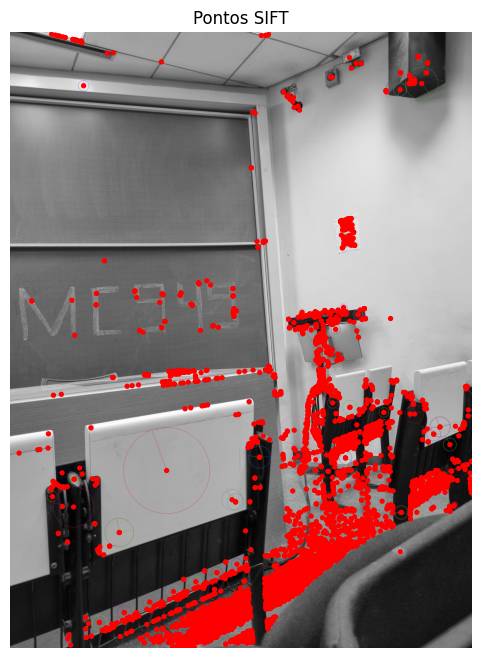

In [17]:
### DETECÇÃO DE PONTOS SIFT ###

# Caminho para a imagem (substitua pelo caminho correto)
caminho_imagem = 'Jasmine - Normal - Apoio Mesa - Quadros CB11/apoioMesa001.jpg'

# Chama a função para calcular os pontos SIFT
imagem, keypoints, desc = calcular_pontos_sift(caminho_imagem)

# Destaca os pontos na imagem
imagem_com_pontos = cv2.drawKeypoints(imagem, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Mostra a imagem com os pontos destacados em uma janela
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(imagem_com_pontos, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Pontos SIFT')

# Aumenta o tamanho dos círculos dos keypoints manualmente
for kp in keypoints:
    x, y = kp.pt
    plt.gca().add_patch(plt.Circle((x, y), radius=8, color='red', fill=False, linewidth=2))

plt.show()

In [18]:
def encontrar_matches_flann(
    descriptors1: np.ndarray,
    descriptors2: np.ndarray,
    ratio_test: float = 0.75
) -> List[cv2.DMatch]:
    """
    Recebe os caminhos para duas imagens, seus keypoints e descritores, e retorna os matches entre os keypoints usando FLANN.

    Args:
        caminho_imagem1 (str): Caminho para a primeira imagem.
        caminho_imagem2 (str): Caminho para a segunda imagem.
        keypoints1 (List[cv2.KeyPoint]): Keypoints da primeira imagem.
        descriptors1 (np.ndarray): Descritores da primeira imagem.
        keypoints2 (List[cv2.KeyPoint]): Keypoints da segunda imagem.
        descriptors2 (np.ndarray): Descritores da segunda imagem.
        ratio_test (float): Valor do teste de razão de Lowe (default 0.75).

    Returns:
        List[cv2.DMatch]: Lista de matches filtrados.
    """
    # FLANN parameters for SIFT/AKAZE (float descriptors)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_test * n.distance:
            good_matches.append(m)
    return good_matches

In [19]:
def encontrar_matches_bruteforce(
    descriptors1: np.ndarray,
    descriptors2: np.ndarray,
    ratio_test: float = 0.75
) -> List[cv2.DMatch]:
    """
    Encontra os matches entre dois conjuntos de descritores usando o Brute Force Matcher.

    Args:
        descriptors1 (np.ndarray): Descritores da primeira imagem.
        descriptors2 (np.ndarray): Descritores da segunda imagem.
        ratio_test (float): Valor do teste de razão de Lowe (default 0.75).

    Returns:
        List[cv2.DMatch]: Lista de matches filtrados.
    """
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < ratio_test * n.distance:
            good_matches.append(m)
    return good_matches

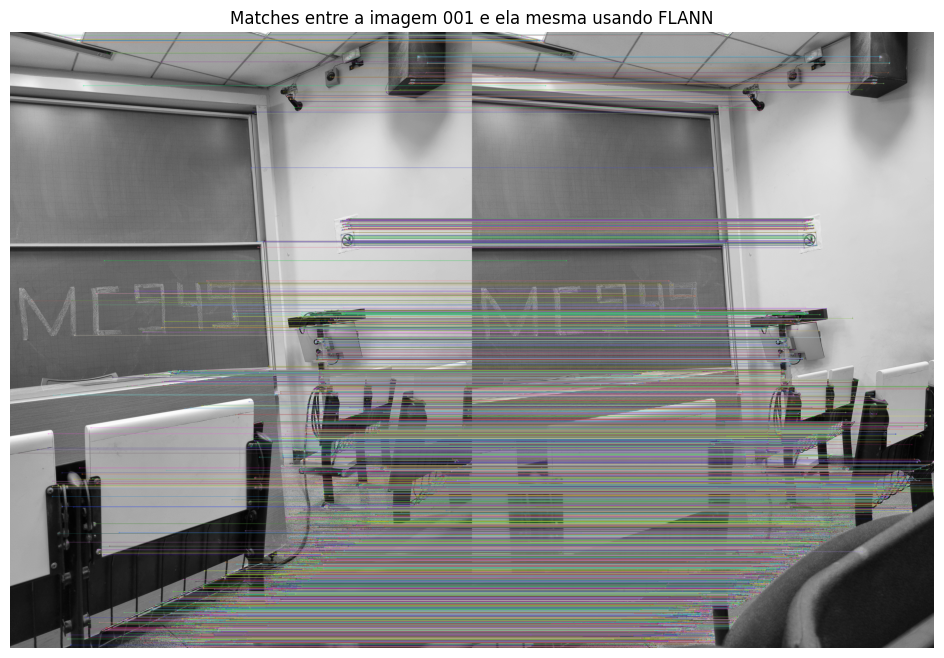

In [21]:
# Calcula os matches entre a imagem 001 e ela mesma usando FLANN
matches = encontrar_matches_flann(desc, desc, ratio_test=0.75)

# Desenha os matches entre a imagem e ela mesma
imagem_matches = cv2.drawMatches(
    imagem, list(keypoints),
    imagem, list(keypoints),
    matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(imagem_matches, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Matches entre a imagem 001 e ela mesma usando FLANN')
plt.show()